In [1]:
import os
import cv2
import numpy as np
import glob
import PIL.Image as Image
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from utils import *
from copy import deepcopy
plt.rcParams['figure.figsize'] = [36, 18]
plt.rcParams['font.size'] = 16
from skimage.io import imread
from skimage import data, io, img_as_float, exposure
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default='notebook'

/home/cmt/.local/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning:

Low image data range; displaying image with stretched contrast.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


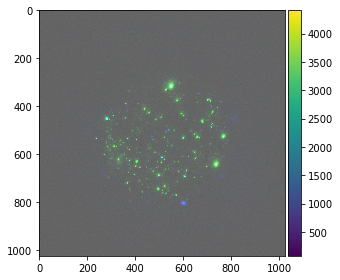

In [2]:
PATH = "images"
file_name = "wt basal 016.tif"
im = imread(os.path.join(PATH, file_name), plugin="tifffile")
io.imshow(im)

In [3]:
size = 1024
sensitivities = [160,190,160]

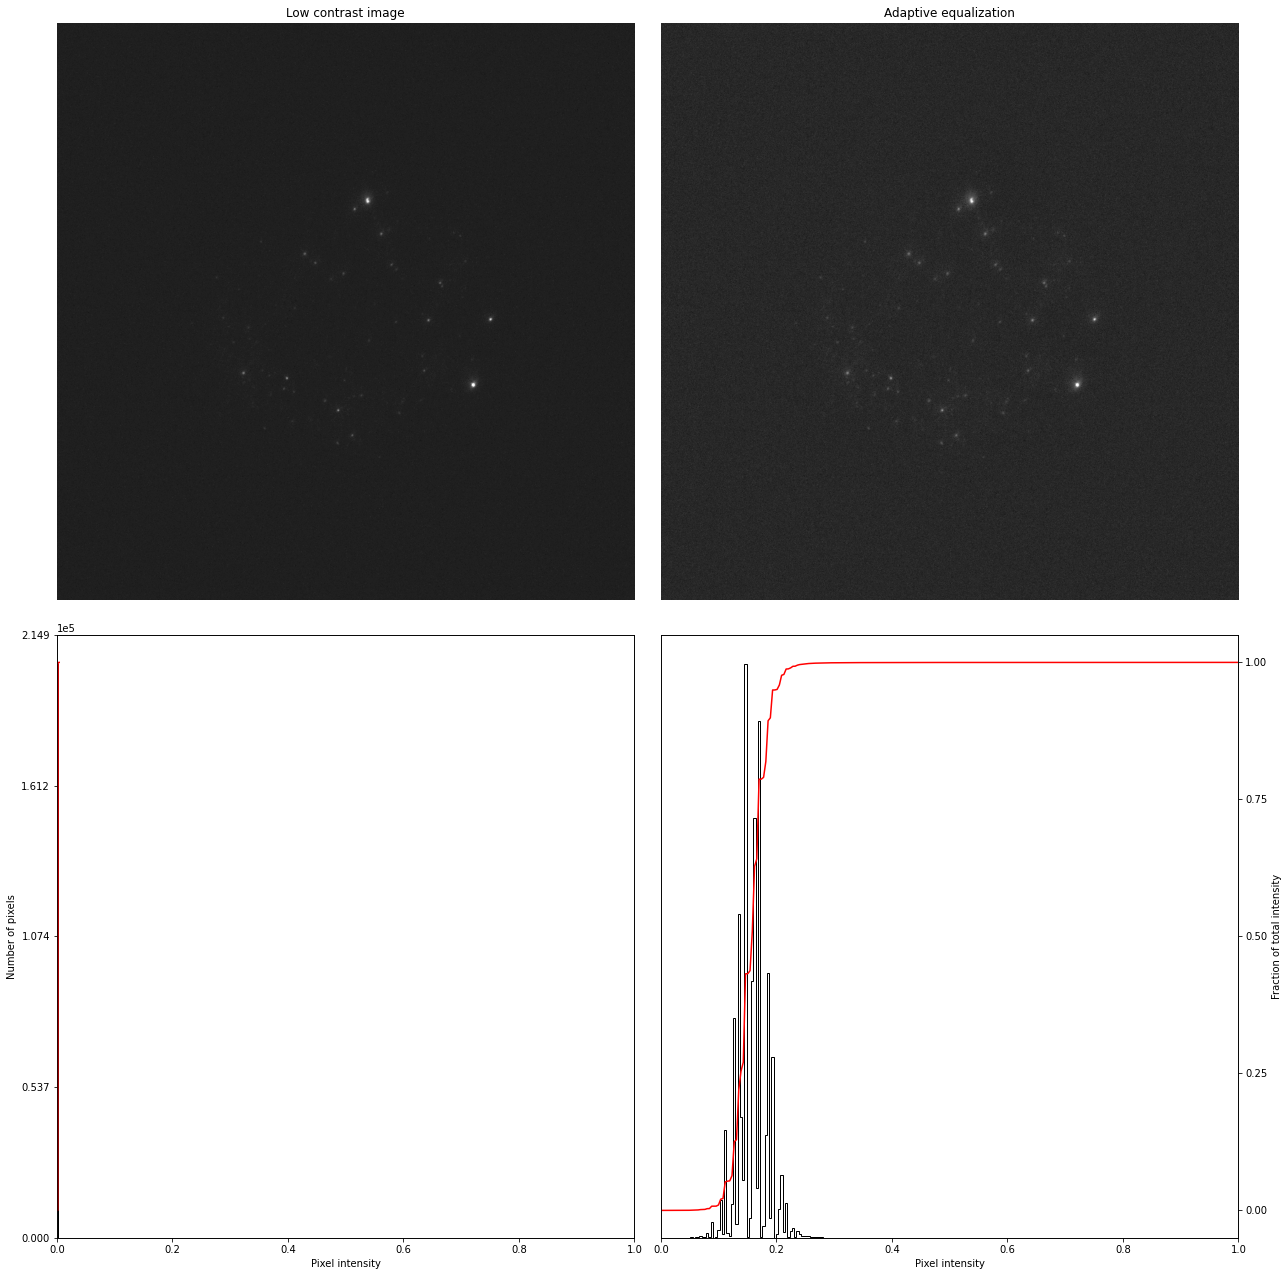

In [4]:
# Load channel
img = im[:,:,0]
R_chan, R_chan_adapteq = plot_equalizations(img, clip_limit=0.01)

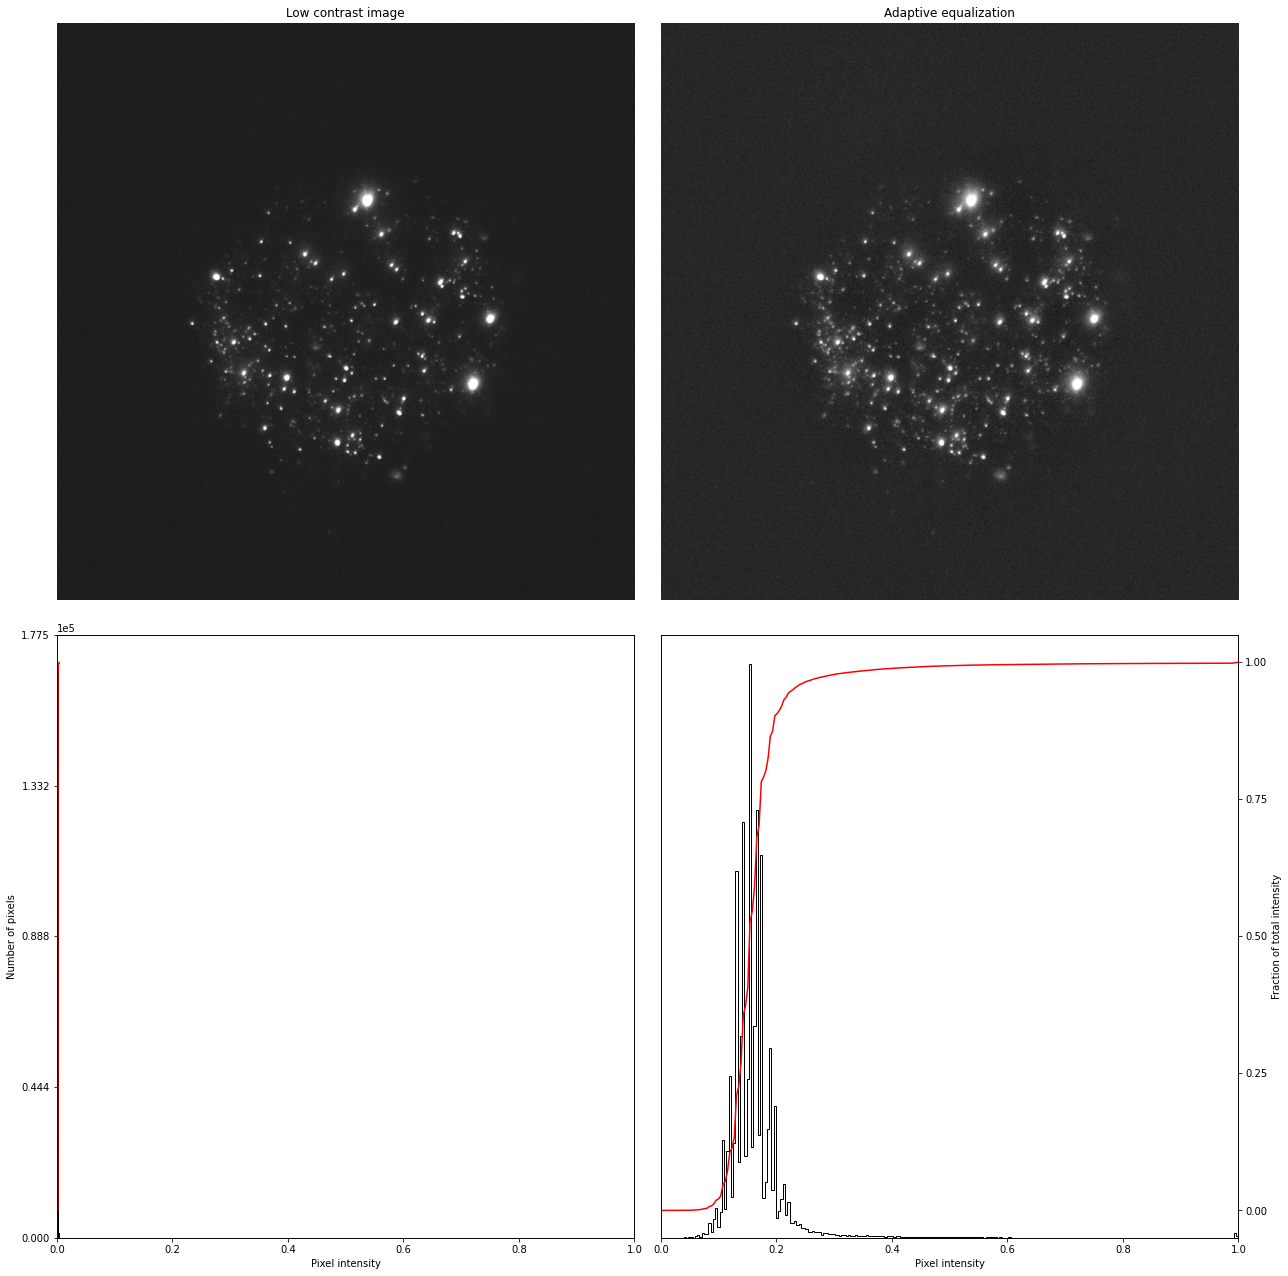

In [5]:
# Load channel
img = im[:,:,1]
G_chan, G_chan_adapteq = plot_equalizations(img, clip_limit=0.01)

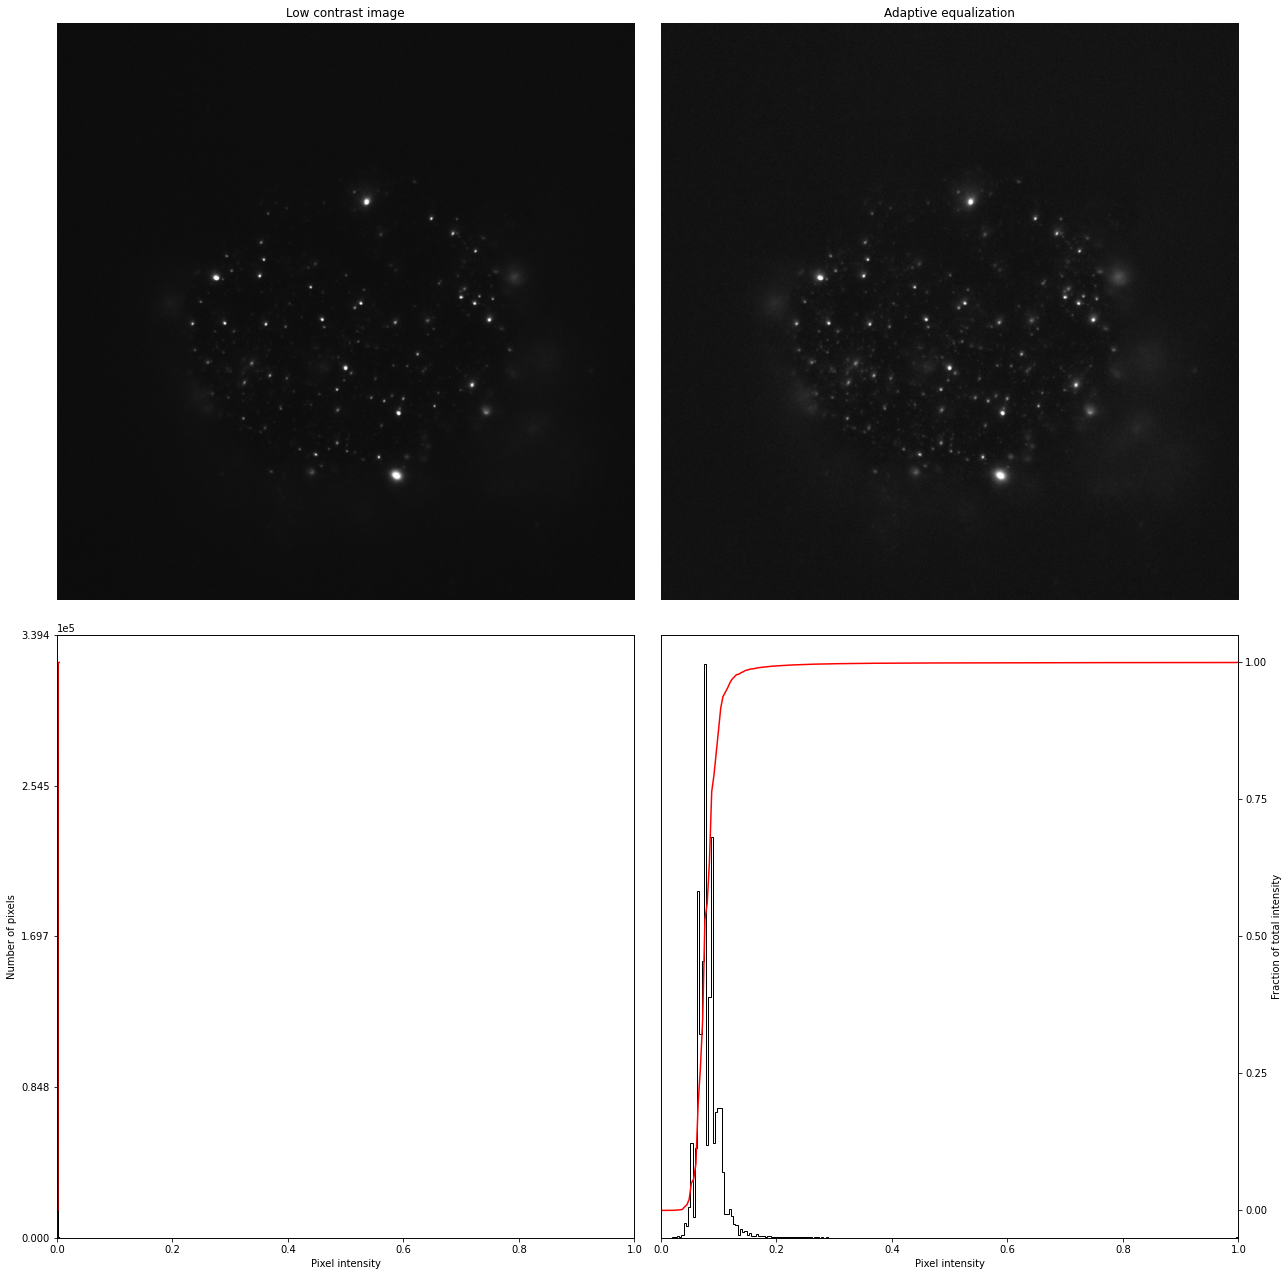

In [6]:
# Load channel
img = im[:,:,2]
B_chan, B_chan_adapteq = plot_equalizations(img, clip_limit=0.01)

# Mask extraction


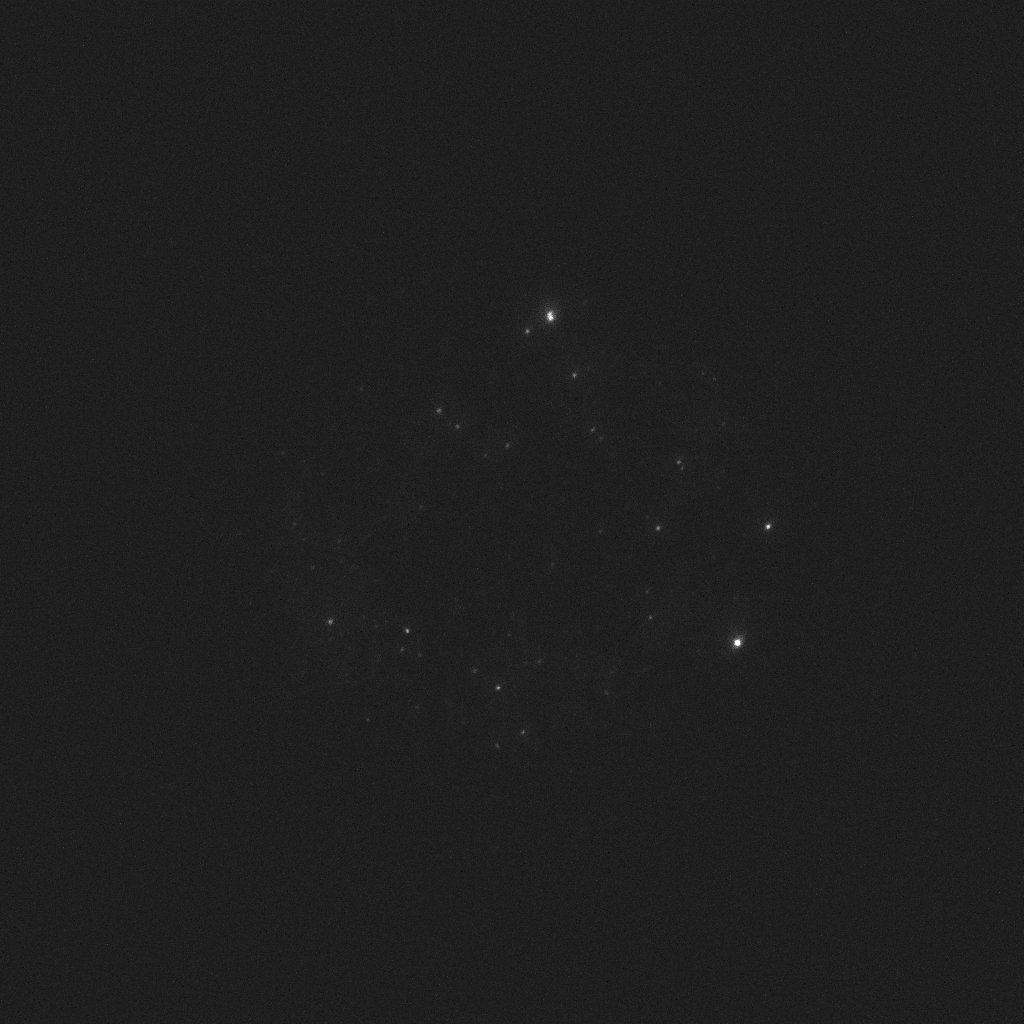
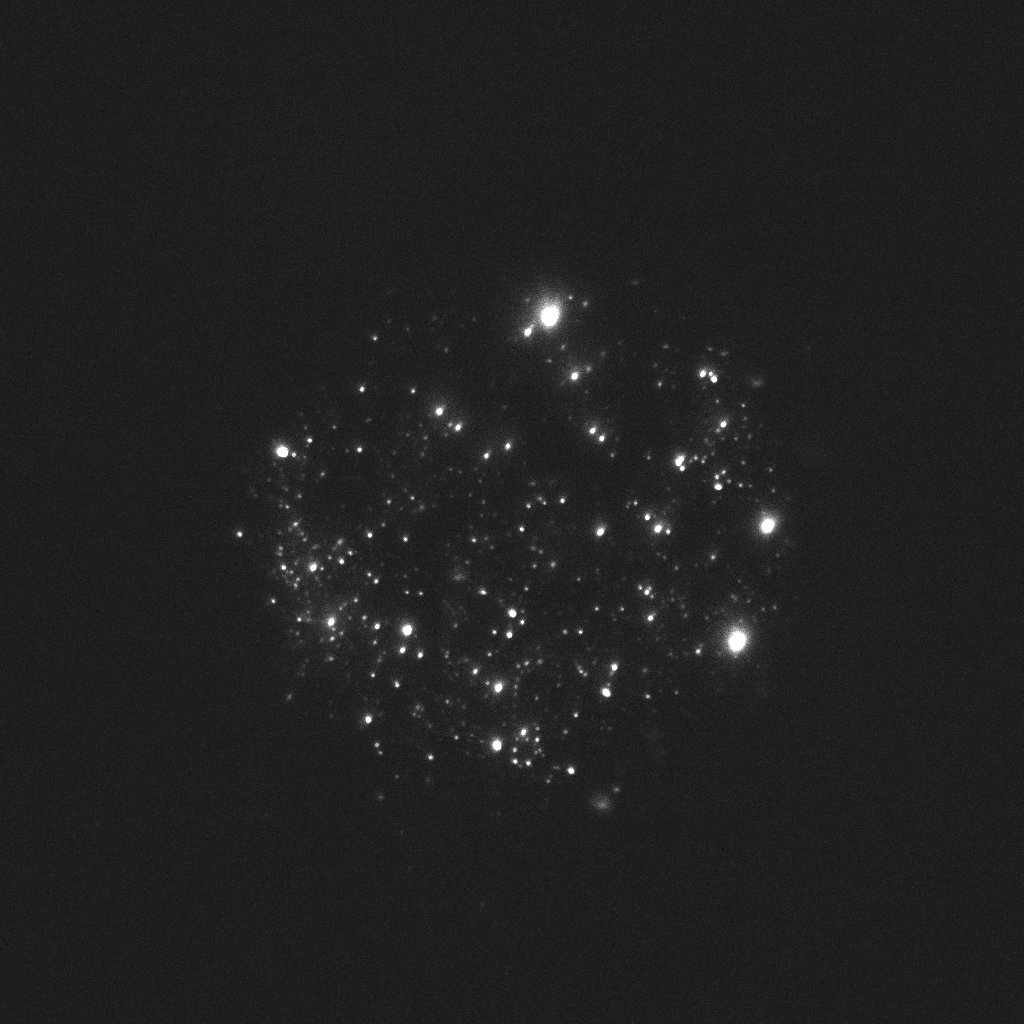
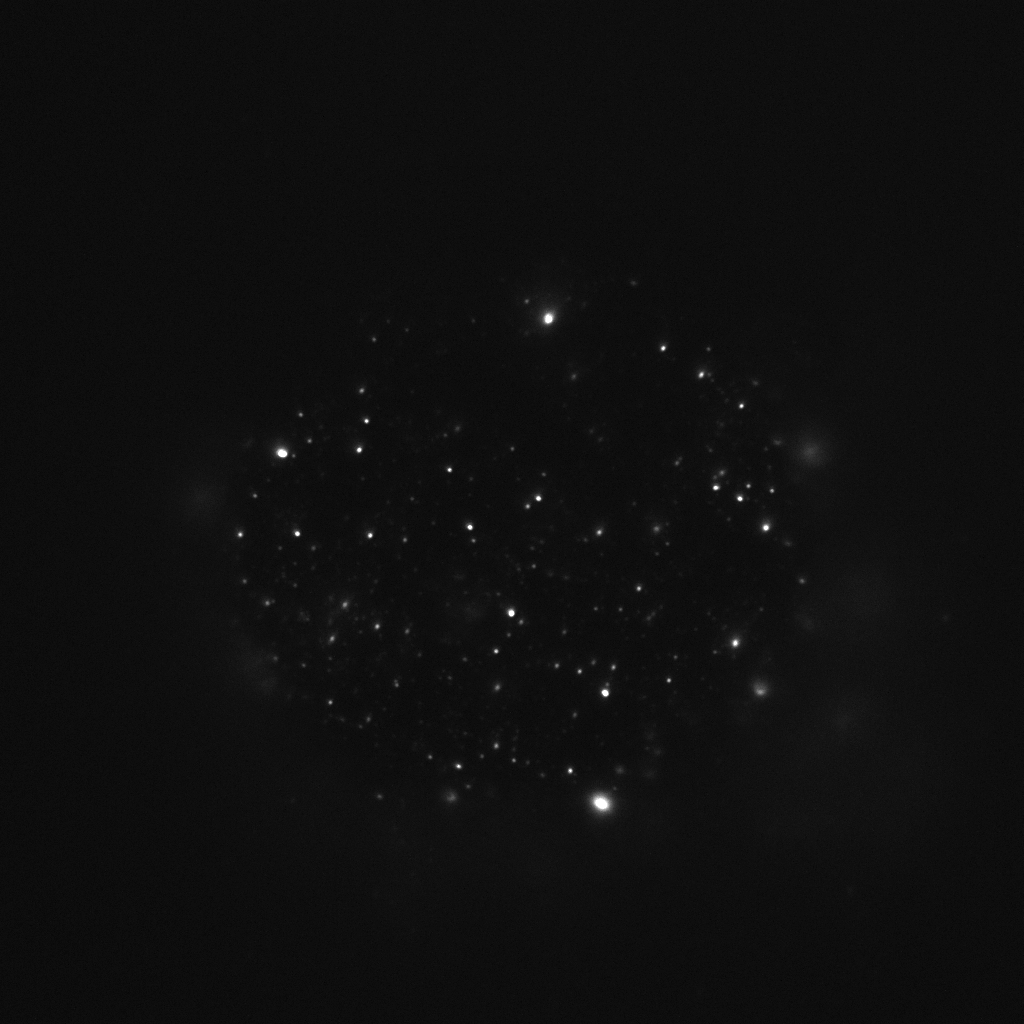

In [7]:
channel_images = [R_chan, G_chan, B_chan]
channel_names = ["Channel 1 (R)", 
                 "Channel 2 (G)", 
                 "Channel 3 (B)"]
detections = {channel_names[0]:0, 
               channel_names[1]:0, 
               channel_names[2]:0}
fig = make_subplots(rows=1,cols=3, shared_xaxes="all", 
                    shared_yaxes="all",
                    subplot_titles = (channel_names[0],
                                      channel_names[1],
                                      channel_names[2]))


df_RGB = pd.DataFrame(columns = ["File", "Channel", "#", "Intensity", "AreaPx"])

for j, image in enumerate(channel_images):
    colors = ["#FF00FF", "#00FF00", "#00BFFF"]

    ch_image = px.imshow(image,
                         color_continuous_scale='gray',
                         binary_string=True, binary_backend="jpg")

    fig = fig.add_trace(ch_image.data[0],
                       row=1, col=j+1)

    fig.update_layout(coloraxis_showscale=False)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)

    mask, contours, hierarchy = extract_masks(image, sensitivities[j])
    detections[channel_names[j]] = len(contours)
    
    for i in range(len(contours)):

        contour_im = cv2.drawContours(deepcopy(mask) , contours, i, (255,0,0),-1, hierarchy=hierarchy, maxLevel = 0)

        contour_idx = np.where(contour_im.flatten()<250)
        noncontour_idx = np.where(contour_im.flatten()>250)

        cropped_mask = deepcopy(image.reshape(-1))
        cropped_mask[contour_idx] = 0 

        intensity = int(np.round(np.mean(cropped_mask[noncontour_idx])))
        area_px = len(cropped_mask[noncontour_idx])
        area_si = 'X'
        
        new_entry = pd.DataFrame(
            {"File" : pd.Series(file_name, dtype="string"),
             "Channel" : pd.Series(j, dtype="int"),
            "#": pd.Series(i, dtype="int"),
            "Intensity": pd.Series(intensity, dtype="int"),
            "AreaPx": pd.Series(area_px, dtype="int")})
        
        df_RGB = pd.concat([df_RGB, new_entry], ignore_index=True)

        cropped_mask = cropped_mask.reshape(size,size)

        x_con = contours[i].reshape(contours[i].shape[0],-1)[:,0]
        y_con = contours[i].reshape(contours[i].shape[0],-1)[:,1]
        hoverinfo = f"Intensity: {intensity}/255<br>Area: {area_px} px | {area_si} μm²"
        fig.add_scatter(x=x_con, y=y_con, 
                        mode="lines",
                        fill="toself",
                        line=dict(color=colors[j]),
                        showlegend=False,
                        hovertemplate=hoverinfo,
                        hoveron="points+fills",
                        name=f"#{i+1}",
                        row=1, col=j+1
                       )
    fig.layout.annotations[j].update(y=0.9)
fig.for_each_annotation(lambda a: a.update(text = a.text + "    #Detections: "+str(detections[a.text])))
fig['layout'].update(height=image.shape[1]*0.8, 
                     width=image.shape[1]*1.7)

fig.show()


if not os.path.exists(os.path.join("results", file_name)):
    os.mkdir(os.path.join("results", file_name))


df_RGB.to_csv(f"results/{file_name}/info.csv")
fig.write_html(f"results/{file_name}/detections.html")



In [13]:
import plotly.graph_objects as go
import plotly.express as px
pio.renderers.default='svg'
def create_RGBboxplot(df_RGB, column):
    
    fig = px.box(df_RGB, x="Channel", y=column, color="File")
    fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
    fig.show()
    
    if not os.path.exists("statistics"):
        os.mkdir("statistics")
    fig.write_html(f"statistics/boxplot_{column}.html")
    fig.write_image(f"statistics/boxplot_{column}.svg")
    fig.write_image(f"statistics/boxplot_{column}.pdf")

    return fig

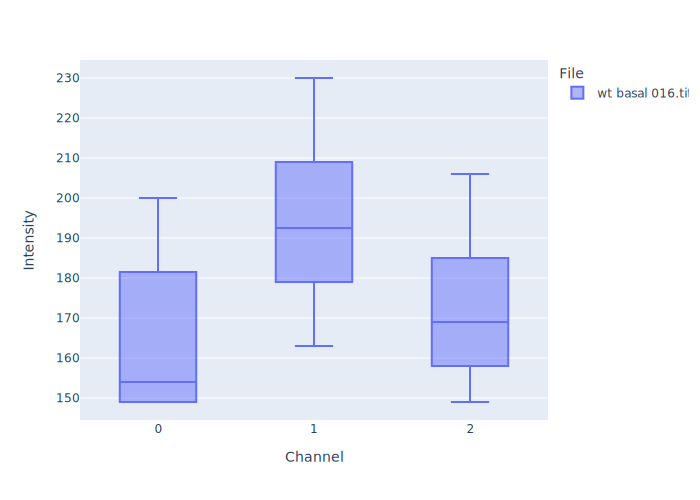

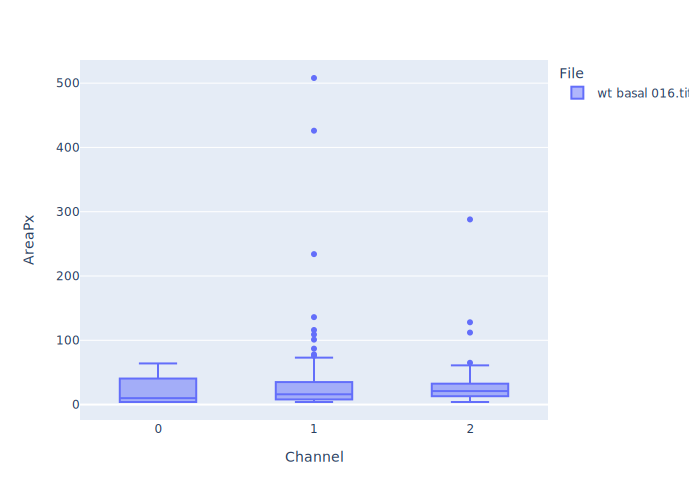

In [16]:

def compute_statistics(images_names):
    
    df_RGB = pd.DataFrame(columns = ["File", "Channel", "#", "Intensity", "AreaPx"])

    for image_name in images_names:
        df_RGB = pd.concat([df_RGB, pd.read_csv(os.path.join("results", image_name, "info.csv"))], ignore_index=True)
    
    create_RGBboxplot(df_RGB, "Intensity")
    create_RGBboxplot(df_RGB, "AreaPx")
                         
        
images_list = ["wt basal 016.tif"]#, "nextimage", "nextimage2"]
compute_statistics(images_list)